# Tick Data Exploring

In [1]:
from datetime import datetime, timedelta
import pandas as pd
import numpy as np
import binance_helpers as bh
import time
import matplotlib.pyplot as plt

In [2]:
client = bh.new_binance_client()

In [3]:
start, pair = int(datetime(2022, 1, 7, 7, 45, 19).timestamp()*1000), "XTZUSDT" #24 @4.21    X
# start, pair = int(datetime(2022, 1, 6, 8, 14, 53).timestamp()*1000), "ADAUSDT" #55          X
# start, pair = int(datetime(2021, 12, 30, 7, 40, 28).timestamp()*1000), "LINKUSDT" #31       X
# start, pair = int(datetime(2021, 12, 23, 8, 43, 51).timestamp()*1000), "XLMUSDT" #52        √
# start, pair = int(datetime(2021, 12, 18, 8, 21, 6).timestamp()*1000), "GALAUSDT" #          √
# start, pair = int(datetime(2021, 12, 11, 7, 44, 26).timestamp()*1000), "NEARUSDT" #27       X
# start, pair = int(datetime(2021, 12, 9, 8, 31, 51).timestamp()*1000), "MATICUSDT" #52       √
# start, pair = int(datetime(2021, 12, 2, 10, 52, 2).timestamp()*1000), "SOLUSDT" #           √
# start, pair = int(datetime(2021, 11, 26, 7, 34, 32).timestamp()*1000), "AXSUSDT" #          ?
# start, pair = int(datetime(2021, 11, 23, 7, 47, 30).timestamp()*1000), "ONEUSDT" #          √
# start, pair = int(datetime(2021, 11, 16, 8, 23, 40).timestamp()*1000), "SANDUSDT" #         X
# start, pair = int(datetime(2021, 11, 11, 8, 23, 23).timestamp()*1000), "MANAUSDT" #         √


In [4]:
# agg_trades = client.get_aggregate_trades(symbol=pair, startTime=start, endTime=start+10000)
agg_trades = client.futures_aggregate_trades(symbol=pair, startTime=start, endTime=start+10000)

In [5]:
len(agg_trades)

295

In [6]:
df = pd.DataFrame(list(map(lambda x: float(x['p']), agg_trades)), 
                  index=list(map(lambda x: datetime.fromtimestamp(x['T'] / 1e3), agg_trades)), 
                  columns=['price'])
df['q'] = list(map(lambda x: float(x['q']), agg_trades))
df['m'] = list(map(lambda x: x['m'], agg_trades))

In [7]:
d = df.groupby(df.index)
df1 = pd.DataFrame({"price":d.mean().price,
                   "q": d.sum().q,
                   "m":df[~df.index.duplicated(keep='first')].m},
                  index=d.mean().index)

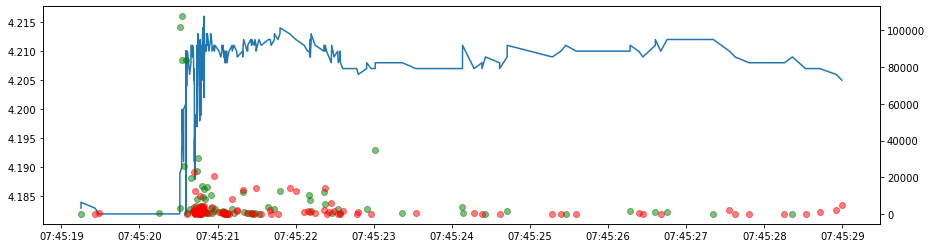

In [8]:
fig, ax = plt.subplots(figsize=(15,4))
m = df1[df1.m==False][:]
m_ = df1[df1.m][:]
ax.plot(df.index, df.price)
ax1 = ax.twinx()
ax1.scatter(m.index, m.q*m.price, color='green', alpha=0.5)
ax1.scatter(m_.index, m_.q*m_.price, color='red', alpha=0.5)

In [9]:
sum(m_.q*m_.price)

239063.55527727274

## First 10 minutes analysis

In [10]:
agg_trades = client.futures_aggregate_trades(symbol=pair, startTime=start, endTime=start+100000, limit=1000)

In [11]:
while agg_trades[-1]['T']<start+5*60*1000:
    time.sleep(0.5)
    agg_trades += client.futures_aggregate_trades(symbol=pair, fromId=str(agg_trades[-1]['a']+1), limit=1000)

In [12]:
len(agg_trades)

2915

In [13]:
df = pd.DataFrame(list(map(lambda x: float(x['p']), agg_trades)), 
                  index=list(map(lambda x: datetime.fromtimestamp(x['T'] / 1e3), agg_trades)), 
                  columns=['price'])
df['q'] = list(map(lambda x: float(x['q']), agg_trades))
df['m'] = list(map(lambda x: x['m'], agg_trades))

In [14]:
d = df.groupby(df.index)
df1 = pd.DataFrame({"price":d.mean().price,
                   "q": d.sum().q,
                   "m":df[~df.index.duplicated(keep='first')].m},
                  index=d.mean().index)

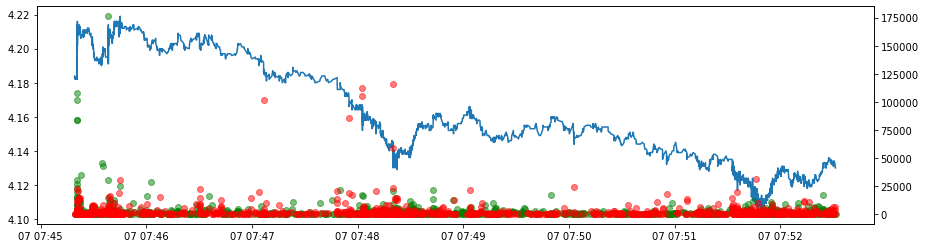

In [15]:
fig, ax = plt.subplots(figsize=(15,4))
m = df1[df1.m==False][:]
m_ = df1[df1.m][:]
ax.plot(df.index, df.price)
ax1 = ax.twinx()
# ax.axhline(20.17)
# ax.axhline(20.17*1.005)

ax1.scatter(m.index, m.q*m.price, color='green', alpha=0.5)
ax1.scatter(m_.index, m_.q*m_.price, color='red', alpha=0.5)

## Latter analysis

In [16]:
s = datetime.utcfromtimestamp(start/1000).strftime("%d %b %Y %H:%M:%S")
e = datetime.utcfromtimestamp((start+300*60*1000)/1000).strftime("%d %b %Y %H:%M:%S")

In [17]:
klines = client.futures_historical_klines(symbol=pair, interval = "1m", start_str=s, end_str=e)

In [18]:
df = pd.DataFrame(list(map(lambda x: float(x[4]), klines)), 
                  index=list(map(lambda x: datetime.fromtimestamp(x[0] / 1e3), klines)), 
                  columns=['price'])
df['q'] = list(map(lambda x: float(x[5]), klines))
# df['m'] = list(map(lambda x: x['m'], klines))

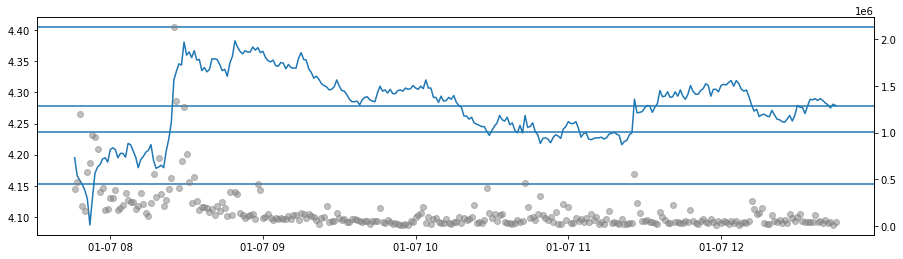

In [19]:
fig, ax = plt.subplots(figsize=(15,4))
ax.plot(df.index, df.price)
ax1 = ax.twinx()
ax.axhline(df.price[0]*0.99)
ax.axhline(df.price[0]*1.01)
ax.axhline(df.price[0]*1.02)
ax.axhline(df.price[0]*1.05)


ax1.scatter(df.index, df.q*df.price, color='gray', alpha=0.5)